### LOAD DATASET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob 
import time
from datetime import datetime
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle

from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

/home/ives/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### DATA PREPROCESSING 

In [3]:
img_h = 224
img_w = 224
def read_img(path,):
    'read, resize, and convert an image to grayscale'
    img = cv2.imread(path)
    resize = cv2.resize(img, (img_h, img_w), cv2.INTER_LINEAR)
    #gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
    return resize

In [4]:
type_paths = glob('/storage/Documents/springboard_capstone/capstone1/train/*')
test_paths = glob('/storage/Documents/springboard_capstone/capstone1/test/*')

In [5]:
train_paths = []
for path in type_paths:
    train_paths += glob(path+'/*')

In [6]:
def load_train(paths):
    train_data = []
    train_target = []
    train_id = []
    start_time = time.time()
    for path in paths:
        train_id.append(path)
        train_data.append(read_img(path))
        target = path.split('/')[-2]
        train_target.append(target)
    print ('Training data load time: {}'.format(time.time() - start_time))
    return train_data, train_target, train_id

def load_test(paths):
    test_data = []
    test_id = []
    start_time = time.time()
    for path in paths:
        test_id.append(path)
        test_data.append(read_img(path))
    print ('Testing data load time: {}'.format(time.time() - start_time))
    return test_data, test_id

In [7]:
train_data, train_target, train_id_ = load_train(train_paths)
test_data, test_id_ = load_test(test_paths)

Training data load time: 288.4631316661835
Testing data load time: 102.9557192325592


In [8]:
def normalize_data(data):
    data = np.array(data, dtype=np.uint8)
    data = data.astype('float32')
    data = data/255
    return data

train_data = normalize_data(train_data)
print ('Shape of the training data is ', train_data.shape)

Shape of the training data is  (1481, 224, 224, 3)


In [9]:
test_data = normalize_data(test_data)
print ('Shape of the training data is ', test_data.shape)

Shape of the training data is  (503, 224, 224, 3)


In [10]:
# Convert train_target to one-hot-encoding before fitting into the model
train_label = [int(x.split('_')[1]) for x in train_target]
train_label = np_utils.to_categorical(train_label)
train_label = np.transpose(train_label)
train_label = np.transpose(train_label[~(train_label==0).all(axis=1)])

In [11]:
# Create validation split 
X_train, X_valid, Y_train, Y_valid = train_test_split(train_data, train_label, test_size=0.2, random_state=22)

### BUILDING MODELS AND  COMPARING MODEL PERFORMANCE

Let's start our model selection process by building three different models and compare their performance: 
+ The first model is a simple sequential model with 3 blocks of layers including a convolutional layer followed by an activation, a maxpooling 2D layer, and a dropout of 25% layer. 
+ The second model is based on the VGG16 model with an additional flatten block of layers. 
+ The third model will utilize the implementation of ResNet 50 with an additional flatten block of layers. 

While all parameters will be trained in the first model, we will freeze all layers of model 2 and model 3 up to the last added block of layers. This process is known as transfer learning in machine learning. Utilizing transfer learning will help us speed up the process of training a model by using the weights of a trained model. In this case, we will use the weights of imagenet dataset to build model 2 and model 3. After training all three models, we can compare to see the differences in their performance. 

In [12]:
#Define the initial training hyperparameters
epochs = 50
batch_size = 16

In [13]:
#Define early stopping callback in case needed
patience = 10
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.05, 
                              patience = patience, verbose=0, mode='auto')

### Sequential Model with 3 convolution layers with a ReLU activation and max_pooling

In [14]:
#Build the first model with a simple stack of 3 convolution layers with a ReLU activation and max_pooling

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last', name='block1_Conv2D'))
model1.add(Activation('relu', name='block1_Activation'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_MaxPooling2D'))
model1.add(Dropout(0.25, name='block1_Dropout'))

model1.add(Conv2D(64, (3, 3), data_format='channels_last', name='block2_Conv2D'))
model1.add(Activation('relu', name='block2_Activation'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_MaxPooling2D'))
model1.add(Dropout(0.25, name='block2_Dropout'))

model1.add(Conv2D(128, (3,3), data_format='channels_last', name='block3_Conv2D'))
model1.add(Activation('relu', name='block3_Activation'))
model1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_MaxPooling2D'))
model1.add(Dropout(0.25, name='block3_Dropout'))

#Add flatten
model1.add(Flatten(name='block4_Flatten'))
model1.add(Dense(256, activation='relu', name='block4_Dense'))
model1.add(Dropout(0.5, name='block4_Dropout'))
model1.add(Dense(3, activation='softmax', name='block4_Activation'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

In [15]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv2D (Conv2D)       (None, 222, 222, 32)      896       
_________________________________________________________________
block1_Activation (Activatio (None, 222, 222, 32)      0         
_________________________________________________________________
block1_MaxPooling2D (MaxPool (None, 111, 111, 32)      0         
_________________________________________________________________
block1_Dropout (Dropout)     (None, 111, 111, 32)      0         
_________________________________________________________________
block2_Conv2D (Conv2D)       (None, 109, 109, 64)      18496     
_________________________________________________________________
block2_Activation (Activatio (None, 109, 109, 64)      0         
_________________________________________________________________
block2_MaxPooling2D (MaxPool (None, 54, 54, 64)        0         
__________

In [20]:
start_time = time.time()

modelcheckpoint = ModelCheckpoint('model1_checkpoint/checking_epochs_model1.h5', 
                                  monitor='val_acc', 
                                  verbose=0,
                                  save_best_only=True, 
                                  mode='auto', period=1)
model1_history = model1.fit(X_train, Y_train, 
         batch_size=batch_size, epochs=epochs, 
         callbacks=[modelcheckpoint],
         validation_data=(X_valid, Y_valid), shuffle=True)

end_time = time.time()
print ('The time for fitting training data into model 1 is {}'.format(end_time-start_time))

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 206s 174ms/step - loss: 1.0503 - acc: 0.5169 - val_loss: 1.0171 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 202s 170ms/step - loss: 1.0058 - acc: 0.5312 - val_loss: 1.0161 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 198s 167ms/step - loss: 0.9998 - acc: 0.5312 - val_loss: 1.0154 - val_acc: 0.5118
Epoch 4/50
1184/1184 [==============================] - 198s 168ms/step - loss: 0.9973 - acc: 0.5312 - val_loss: 1.0171 - val_acc: 0.5118
Epoch 5/50
1184/1184 [==============================] - 201s 170ms/step - loss: 0.9979 - acc: 0.5312 - val_loss: 1.0161 - val_acc: 0.5118
Epoch 6/50
1184/1184 [==============================] - 196s 166ms/step - loss: 0.9972 - acc: 0.5312 - val_loss: 1.0160 - val_acc: 0.5118
Epoch 7/50
1184/1184 [==============================] - 197s 166ms/step - loss: 0.9968 - acc: 0.5312 - val_loss: 1.0177 - val

/home/ives/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


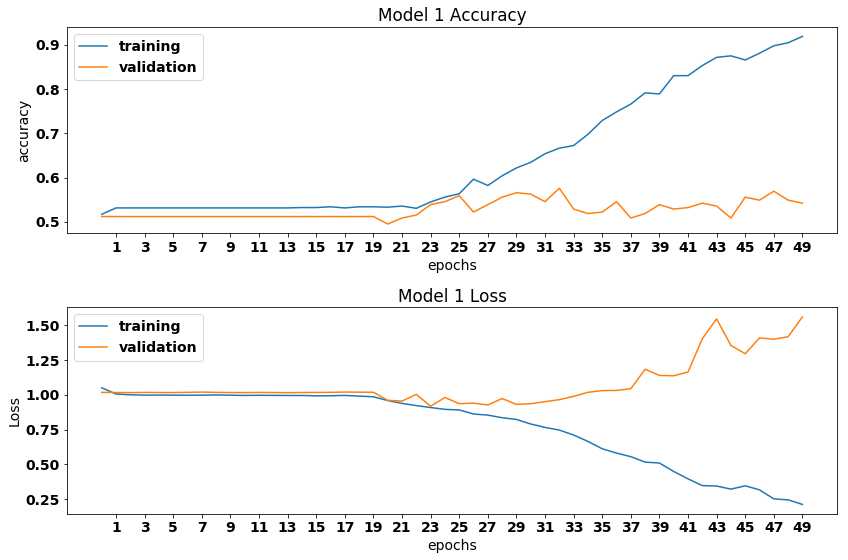

In [35]:
fig1 = plt.figure(figsize=(12,8))
font = {'size'   : 14}
plt.rc('font', **font)

ax1 = fig1.add_subplot(2,1,1)
ax1.plot(model1_history.history['acc'], label='training')
ax1.plot(model1_history.history['val_acc'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.set_title('Model 1 Accuracy')
ax1.set_xticks(range(1,50,2))
ax1.legend()

ax2 = fig1.add_subplot(2,1,2)
ax2.plot(model1_history.history['loss'], label='training')
ax2.plot(model1_history.history['val_loss'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Model 1 Loss')
ax2.set_xticks(range(1,50,2))
ax2.legend()

fig1.tight_layout()

In [38]:
model1.save_weights('model1.h5')

### Very Deep Convolutional NetWorks for Large-Scale Image Recognition (VGG16 Model)

In [16]:
from keras.applications.vgg16 import VGG16
from keras.models import Model 

vgg16_model = VGG16(weights = 'imagenet', include_top=False, 
                   input_shape=(img_w, img_h, 3))

#Freeze all layers in VGG16 model before adding a new block of layers to build the architecture of model2 
for layer in vgg16_model.layers:
    layer.trainable = False
    
vgg16_model.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

top_model = Sequential()
top_model.add(Flatten(input_shape = vgg16_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3,activation='softmax'))

model2 = Model(input=vgg16_model.input, output=top_model(vgg16_model.output))
model2.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

/home/ives/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [17]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
start_time = time.time()

modelcheckpoint = ModelCheckpoint('model1_checkpoint/checking_epochs_model2.h5', 
                                  monitor='val_acc', 
                                  verbose=0,
                                  save_best_only=True, 
                                  mode='auto', period=1)

model2_history = model2.fit(X_train, Y_train, 
                            batch_size=batch_size, epochs=epochs, 
                            callbacks=[modelcheckpoint, early_stopping], 
                            validation_data=(X_valid, Y_valid), shuffle=True)

end_time = time.time()
print ('The time for fitting training data into model 2 is {}'.format(end_time-start_time))

model2.save_weights('model2.h5')

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 1432s 1s/step - loss: 7.4928 - acc: 0.5270 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 1437s 1s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 1435s 1s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 4/50
1184/1184 [==============================] - 1437s 1s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 5/50
1184/1184 [==============================] - 1435s 1s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 6/50
1184/1184 [==============================] - 1434s 1s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 7/50
1184/1184 [==============================] - 1421s 1s/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
E

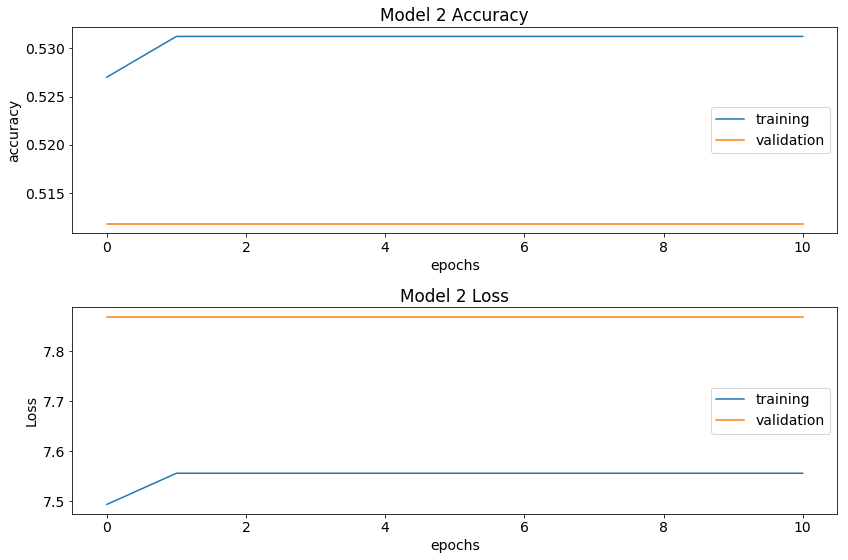

In [26]:
fig2 = plt.figure(figsize=(12,8))
font = {'size'   : 14}
plt.rc('font', **font)

ax1 = fig2.add_subplot(2,1,1)
ax1.plot(model2_history.history['acc'], label='training')
ax1.plot(model2_history.history['val_acc'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.set_title('Model 2 Accuracy')
ax1.legend()

ax2 = fig2.add_subplot(2,1,2)
ax2.plot(model2_history.history['loss'], label='training')
ax2.plot(model2_history.history['val_loss'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Model 2 Loss')
ax2.legend()

fig2.tight_layout()

### ResNet Model

In [19]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model 

resnet50_model = ResNet50(weights = 'imagenet', include_top=False, 
                   input_shape=(img_w, img_h, 3))

#Freeze all layers in resnet50 model
for layer in resnet50_model.layers:
    layer.trainable = False
resnet50_model.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

add_model = Sequential()
add_model.add(Flatten(input_shape =resnet50_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(3,activation='softmax'))

model3 = Model(input=resnet50_model.input, output=add_model(resnet50_model.output))
model3.compile(loss='categorical_crossentropy', 
             optimizer=sgd,
             metrics = ['accuracy'])

/home/ives/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ives/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`


In [20]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
start_time = time.time()

modelcheckpoint = ModelCheckpoint('model1_checkpoint/checking_epochs_model3.h5', 
                                  monitor='val_acc', 
                                  verbose=0,
                                  save_best_only=True, 
                                  mode='auto', period=1)

model3_history = model3.fit(X_train, Y_train, 
                            batch_size=batch_size, epochs=epochs, 
                            callbacks=[early_stopping, modelcheckpoint], 
                            validation_data=(X_valid, Y_valid), shuffle=True)

end_time = time.time()
print ('The time for fitting training data into model 3 is {}'.format(end_time-start_time))

model3.save_weights('model3.h5')

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 837s 707ms/step - loss: 7.5800 - acc: 0.5211 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 819s 692ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 822s 694ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 4/50
1184/1184 [==============================] - 823s 695ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 5/50
1184/1184 [==============================] - 822s 695ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 6/50
1184/1184 [==============================] - 818s 691ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val_acc: 0.5118
Epoch 7/50
1184/1184 [==============================] - 814s 687ms/step - loss: 7.5554 - acc: 0.5312 - val_loss: 7.8691 - val

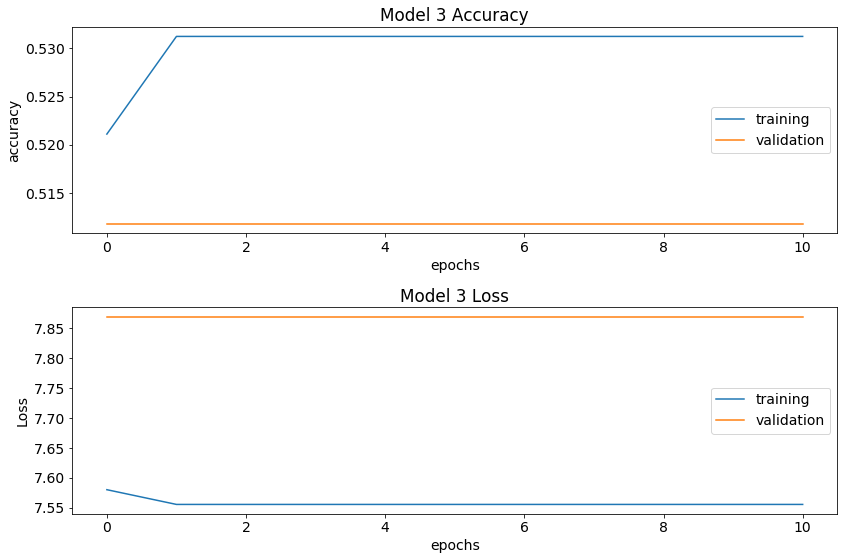

In [27]:
fig3 = plt.figure(figsize=(12,8))
font = {'size'   : 14}
plt.rc('font', **font)

ax1 = fig3.add_subplot(2,1,1)
ax1.plot(model3_history.history['acc'], label='training')
ax1.plot(model3_history.history['val_acc'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.set_title('Model 3 Accuracy')
ax1.legend()

ax2 = fig3.add_subplot(2,1,2)
ax2.plot(model3_history.history['loss'], label='training')
ax2.plot(model3_history.history['val_loss'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Model 3 Loss')
ax2.legend()

fig3.tight_layout()

### TUNING THE NUMBER OF LAYERS FOR MODEL1 

In [19]:
def add_layer_to_model1(n_layers):
    model = Sequential()
    kernel_size=(3,3)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last', name='block1_Conv2D'))
    model.add(Activation('relu', name='block1_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_MaxPooling2D'))
    model.add(Dropout(0.25, name='block1_Dropout'))

    model.add(Conv2D(64, (3, 3), data_format='channels_last', name='block2_Conv2D'))
    model.add(Activation('relu', name='block2_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_MaxPooling2D'))
    model.add(Dropout(0.25, name='block2_Dropout'))

    model.add(Conv2D(128, (3,3), data_format='channels_last', name='block3_Conv2D'))
    model.add(Activation('relu', name='block3_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_MaxPooling2D'))
    model.add(Dropout(0.25, name='block3_Dropout'))
    
    for i in range(n_layers):
        model.add(Conv2D(128, kernel_size, data_format='channels_last', name='added_layer_{}1'.format(str(i+1))))
        model.add(Activation('relu', name='added_layer_{}2'.format(str(i+1))))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='added_layer_{}3'.format(str(i+1))))
        model.add(Dropout(0.25, name='added_layer_{}4'.format(str(i+1))))
            
    #Add flatten
    model.add(Flatten(name='block4_Flatten'))
    model.add(Dense(256, activation='relu', name='block4_Dense'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax', name='block4_Activation'))
        

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer = sgd, 
                 metrics=['accuracy'])
    return model

In [20]:
model1 = add_layer_to_model1(0)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv2D (Conv2D)       (None, 222, 222, 32)      896       
_________________________________________________________________
block1_Activation (Activatio (None, 222, 222, 32)      0         
_________________________________________________________________
block1_MaxPooling2D (MaxPool (None, 111, 111, 32)      0         
_________________________________________________________________
block1_Dropout (Dropout)     (None, 111, 111, 32)      0         
_________________________________________________________________
block2_Conv2D (Conv2D)       (None, 109, 109, 64)      18496     
_________________________________________________________________
block2_Activation (Activatio (None, 109, 109, 64)      0         
_________________________________________________________________
block2_MaxPooling2D (MaxPool (None, 54, 54, 64)        0         
__________

In [24]:
epochs = 25

valid_losses = []
valid_accuracies = []
train_losses = []
train_accuracies = []
histories = []

for i in range(1, 4):
    new_model1 = add_layer_to_model1(i)
    print ('Adding {}'.format(str(i)), 'block of layers into model 1')
    print (new_model1.summary())
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-add-{}-block.h5'.format(str(i)), 
                                        monitor='val_acc', 
                                        verbose=0, save_best_only=True,  
                                        mode='auto', period=1)

    history = new_model1.fit(X_train, Y_train, 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   callbacks=[modelcheckpoint], 
                   validation_data=[X_valid, Y_valid])
    
    histories.append(history)
    
    valid_loss, valid_accuracy = new_model1.evaluate(X_valid, Y_valid)
    train_loss, train_accuracy = new_model1.evaluate(X_train, Y_train)
    
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

Adding 1 block of layers into model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_Conv2D (Conv2D)       (None, 222, 222, 32)      896       
_________________________________________________________________
block1_Activation (Activatio (None, 222, 222, 32)      0         
_________________________________________________________________
block1_MaxPooling2D (MaxPool (None, 111, 111, 32)      0         
_________________________________________________________________
block1_Dropout (Dropout)     (None, 111, 111, 32)      0         
_________________________________________________________________
block2_Conv2D (Conv2D)       (None, 109, 109, 64)      18496     
_________________________________________________________________
block2_Activation (Activatio (None, 109, 109, 64)      0         
_________________________________________________________________
block2_MaxPooling2D (MaxPool (None, 54

Train on 1184 samples, validate on 297 samples
Epoch 1/25
1184/1184 [==============================] - 219s 185ms/step - loss: 1.0209 - acc: 0.5203 - val_loss: 1.0244 - val_acc: 0.5118
Epoch 2/25
1184/1184 [==============================] - 220s 186ms/step - loss: 1.0001 - acc: 0.5312 - val_loss: 1.0159 - val_acc: 0.5118
Epoch 3/25
1184/1184 [==============================] - 219s 185ms/step - loss: 1.0017 - acc: 0.5312 - val_loss: 1.0161 - val_acc: 0.5118
Epoch 4/25
1184/1184 [==============================] - 217s 183ms/step - loss: 1.0023 - acc: 0.5312 - val_loss: 1.0172 - val_acc: 0.5118
Epoch 5/25
1184/1184 [==============================] - 220s 186ms/step - loss: 1.0014 - acc: 0.5312 - val_loss: 1.0187 - val_acc: 0.5118
Epoch 6/25
1184/1184 [==============================] - 217s 183ms/step - loss: 1.0011 - acc: 0.5312 - val_loss: 1.0157 - val_acc: 0.5118
Epoch 7/25
1184/1184 [==============================] - 218s 184ms/step - loss: 0.9982 - acc: 0.5312 - val_loss: 1.0158 - val

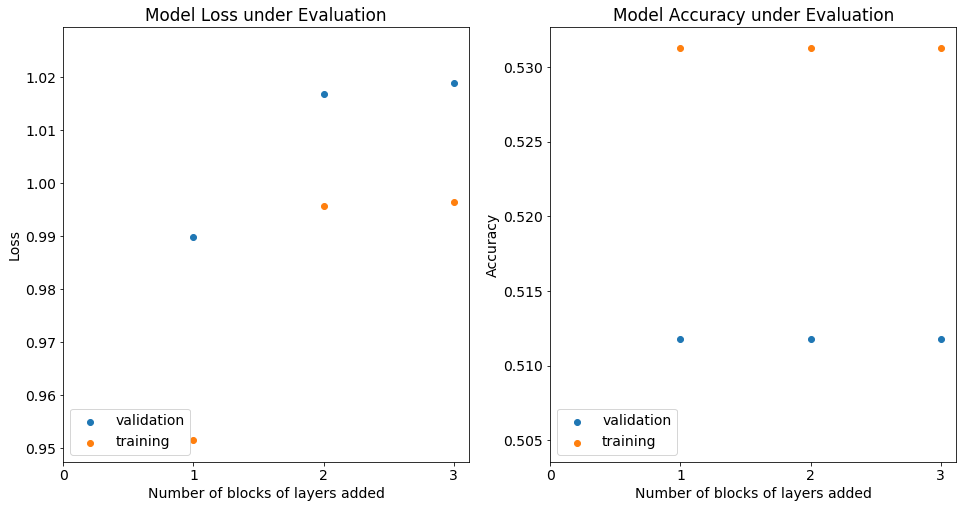

In [28]:
nb_layers = [1, 2, 3]
fig4 = plt.figure(figsize=(16,8))
ax1 = fig4.add_subplot(1,2,1)
ax1.scatter(nb_layers, valid_losses, label='validation')
ax1.scatter(nb_layers, train_losses, label='training')
ax1.set_xlabel('Number of blocks of layers added')
ax1.set_ylabel('Loss')
ax1.set_xticks(range(0,4,1))
ax1.set_title('Model Loss under Evaluation')
ax1.legend(loc='lower left')

ax2 = fig4.add_subplot(1,2,2)
ax2.scatter(nb_layers, valid_accuracies, label='validation')
ax2.scatter(nb_layers, train_accuracies, label='training')
ax2.set_xlabel('Number of blocks of layers added')
ax2.set_ylabel('Accuracy')
ax2.set_xticks(range(0,4,1))
ax2.set_title('Model Accuracy under Evaluation')
ax2.legend(loc='lower left')

### TUNING MODEL 1 USING DIFFERENT ACTIVATION METHOD

In [11]:
def build_model1(activate):
    model = Sequential()
    kernel_size=(3,3)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last', name='block1_Conv2D'))
    model.add(Activation(activate, name='block1_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block1_MaxPooling2D'))
    model.add(Dropout(0.25, name='block1_Dropout'))

    model.add(Conv2D(64, (3, 3), data_format='channels_last', name='block2_Conv2D'))
    model.add(Activation(activate, name='block2_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block2_MaxPooling2D'))
    model.add(Dropout(0.25, name='block2_Dropout'))

    model.add(Conv2D(128, (3,3), data_format='channels_last', name='block3_Conv2D'))
    model.add(Activation(activate, name='block3_Activation'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='block3_MaxPooling2D'))
    model.add(Dropout(0.25, name='block3_Dropout'))
    
    
    #Add flatten
    model.add(Flatten(name='block4_Flatten'))
    model.add(Dense(256, activation=activate, name='block4_Dense'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax', name='block4_Activation'))
        

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer = sgd, 
                 metrics=['accuracy'])
    return model

In [12]:
activation_list = [ 'elu', 'softplus', 'sigmoid', 'linear']

In [16]:
new_activation_valid_losses= []
new_activation_valid_accuracies = []
new_activation_train_losses = []
new_activation_train_accuracies = []
histories_new_activation = []

for activate in activation_list:
    print ('Activation: ', activate)
    new_activation_model1 = build_model1(activate)
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-activation-{}.h5'.format(str(activate)), 
                                        monitor='val_acc', 
                                        verbose=0, save_best_only=True,  
                                        mode='auto', period=1)

    history_new_activate = new_activation_model1.fit(X_train, Y_train, 
                   batch_size=batch_size, 
                   epochs=25, 
                   callbacks=[modelcheckpoint], 
                   validation_data=[X_valid, Y_valid])
    
    histories_new_activation.append(history_new_activate)
    
    valid_loss_new_activate, valid_accuracy_new_activate = new_activation_model1.evaluate(X_valid, Y_valid)
    train_loss_new_activate, train_accuracy_new_activate = new_activation_model1.evaluate(X_train, Y_train)
    
    new_activation_valid_losses.append(valid_loss_new_activate)
    new_activation_valid_accuracies.append(valid_accuracy_new_activate)
    
    new_activation_train_losses.append(train_loss_new_activate)
    new_activation_train_accuracies.append(train_accuracy_new_activate)

Activation:  elu
Train on 1184 samples, validate on 297 samples
Epoch 1/25
1184/1184 [==============================] - 467s 395ms/step - loss: 11.0090 - acc: 0.2889 - val_loss: 11.1796 - val_acc: 0.3064
Epoch 2/25
1184/1184 [==============================] - 503s 425ms/step - loss: 11.2309 - acc: 0.3032 - val_loss: 11.1796 - val_acc: 0.3064
Epoch 3/25
1184/1184 [==============================] - 493s 417ms/step - loss: 11.2309 - acc: 0.3032 - val_loss: 11.1796 - val_acc: 0.3064
Epoch 4/25
1184/1184 [==============================] - 492s 416ms/step - loss: 11.2309 - acc: 0.3032 - val_loss: 11.1796 - val_acc: 0.3064
Epoch 5/25
1184/1184 [==============================] - 502s 424ms/step - loss: 11.2309 - acc: 0.3032 - val_loss: 11.1796 - val_acc: 0.3064
Epoch 6/25
1184/1184 [==============================] - 493s 416ms/step - loss: 11.2309 - acc: 0.3032 - val_loss: 11.1796 - val_acc: 0.3064
Epoch 7/25
1184/1184 [==============================] - 493s 416ms/step - loss: 11.2309 - acc: 0

In [26]:
from keras.models import load_model
model1=load_model('model1_checkpoint/checking_epochs_model1.h5')

In [27]:
model1_relu_valid_loss, model1_relu_valid_accuracy = model1.evaluate(X_valid, Y_valid)
model1_relu_train_loss, model1_relu_train_accuracy = model1.evaluate(X_train, Y_train)

new_activation_valid_losses.append(model1_relu_valid_loss)
new_activation_train_losses.append(model1_relu_train_loss)
new_activation_valid_accuracies.append(model1_relu_valid_accuracy)
new_activation_train_accuracies.append(model1_relu_train_accuracy)
activation_list.append('relu')

1184/1184 [==============================] - 46s 39ms/step


Text(0.5,1,'Model Accuracy under Evaluation for Training Data')

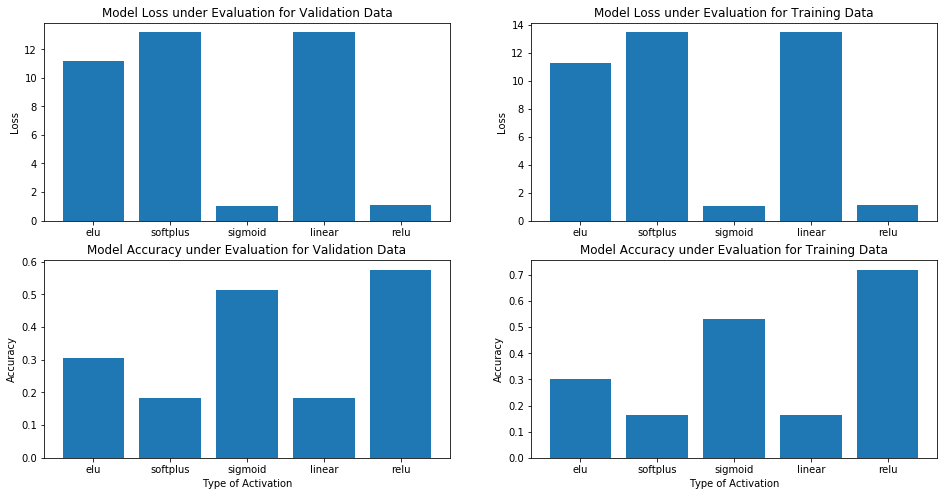

In [28]:
fig5 = plt.figure(figsize=(16,8))
ax1 = fig5.add_subplot(2,2,1)
ax1.bar(activation_list, new_activation_valid_losses, label='validation')
ax2 = fig5.add_subplot(2,2,2)
ax2.bar(activation_list, new_activation_train_losses, label='training')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss under Evaluation for Validation Data')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss under Evaluation for Training Data')

ax3= fig5.add_subplot(2,2,3)
ax3.bar(activation_list, new_activation_valid_accuracies, label='validation')
ax4= fig5.add_subplot(2,2,4)
ax4.bar(activation_list, new_activation_train_accuracies, label='training')
ax3.set_xlabel('Type of Activation')
ax3.set_ylabel('Accuracy')
ax3.set_title('Model Accuracy under Evaluation for Validation Data')
ax4.set_xlabel('Type of Activation')
ax4.set_ylabel('Accuracy')
ax4.set_title('Model Accuracy under Evaluation for Training Data')

### TESTING MODEL1 PERFORMANCE BY REDUCING THE NUMBER OF FEATURES

In [14]:
def reduced_feature_model1(min_num, max_num):
    model = Sequential()
    kernel_size=(3,3)
    for i in range(min_num, max_num):
        model.add(Conv2D(2**i, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))

    
    #Add flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax'))
        

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer = sgd, 
                 metrics=['accuracy'])
    return model

In [15]:
reduced_feature_model1 = reduced_feature_model1(3, 6)
reduced_feature_model1.summary()
modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-reduced_features.h5',
                                  monitor='val_acc', 
                                  verbose=0, save_best_only=True,  
                                  mode='auto', period=1)

history_reduced_features = reduced_feature_model1.fit(X_train, Y_train, 
               batch_size=batch_size, 
               epochs=50, 
               callbacks=[modelcheckpoint], 
               validation_data=[X_valid, Y_valid])


valid_loss_reduced_features, valid_accuracy_reduced_features = reduced_feature_model1.evaluate(X_valid, Y_valid)
train_loss_reduced_features, train_accuracy_reduced_features = reduced_feature_model1.evaluate(X_train, Y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 16)      1168      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 16)        0         
__________

1184/1184 [==============================] - 44s 37ms/step - loss: 0.1552 - acc: 0.9485 - val_loss: 1.6294 - val_acc: 0.5185
Epoch 43/50
1184/1184 [==============================] - 44s 37ms/step - loss: 0.1616 - acc: 0.9451 - val_loss: 1.9998 - val_acc: 0.5488
Epoch 44/50
1184/1184 [==============================] - 46s 39ms/step - loss: 0.1926 - acc: 0.9324 - val_loss: 1.4705 - val_acc: 0.5522
Epoch 45/50
1184/1184 [==============================] - 46s 39ms/step - loss: 0.1820 - acc: 0.9383 - val_loss: 2.0914 - val_acc: 0.5522
Epoch 46/50
1184/1184 [==============================] - 44s 37ms/step - loss: 0.1979 - acc: 0.9383 - val_loss: 1.4970 - val_acc: 0.5219
Epoch 47/50
1184/1184 [==============================] - 46s 38ms/step - loss: 0.1821 - acc: 0.9324 - val_loss: 1.4671 - val_acc: 0.5354
Epoch 48/50
1184/1184 [==============================] - 43s 36ms/step - loss: 0.1421 - acc: 0.9451 - val_loss: 1.7709 - val_acc: 0.5657
Epoch 49/50
1184/1184 [==============================

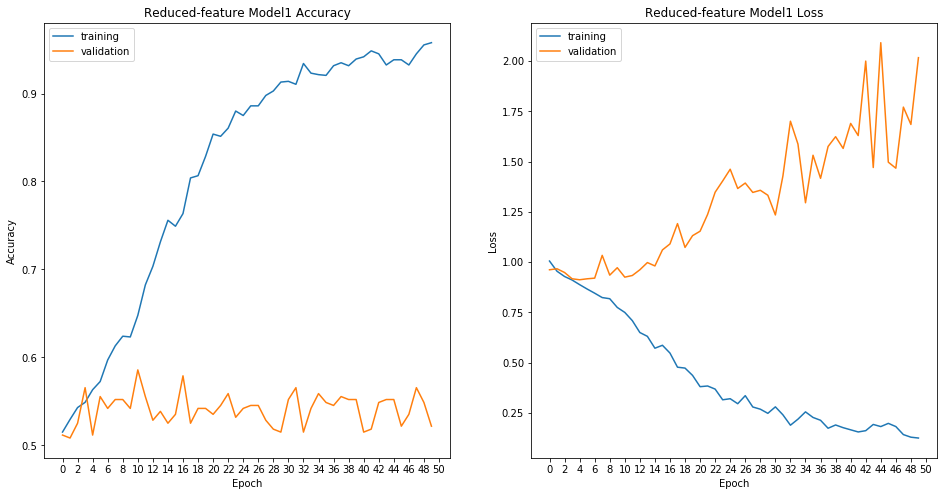

In [16]:
fig6 = plt.figure(figsize=(16,8))
ax1 = fig6.add_subplot(1, 2, 1)
ax1.plot(history_reduced_features.history['acc'], label='training')
ax1.plot(history_reduced_features.history['val_acc'], label='validation')
ax1.set_title('Reduced-feature Model1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_xticks(range(0,52,2))
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2 = fig6.add_subplot(1, 2, 2)
ax2.plot(history_reduced_features.history['loss'], label='training')
ax2.plot(history_reduced_features.history['val_loss'], label='validation')
ax2.set_title('Reduced-feature Model1 Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')
ax2.set_xticks(range(0,52,2))

plt.show()

### TUNING MODEL1 ON DIFFERENT COMBINATION OF OPTIMIZER AND LOSS FUNCTION

In [17]:
def model1_test_combination(loss_function, optimizer):
    model = Sequential()
    kernel_size=(3,3)
    for i in range(3, 6):
        model.add(Conv2D(2**i, (3, 3), input_shape=(img_h, img_w, 3), data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))

    
    #Add flatten
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5, name='block4_Dropout'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss=loss_function, optimizer = optimizer, 
                 metrics=['accuracy'])   
    return model

In [18]:
from keras import optimizers
loss_functions = ['mean_squared_error', 
                 'categorical_crossentropy', 
                 'binary_crossentropy']

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

optimizers = [sgd, adadelta, adam]

In [19]:
combinations = [loss_functions, optimizers]
import itertools
combinations = list(itertools.product(*combinations))
print ('The number of combinations is ', len(combinations))

The number of combinations is  9


In [21]:
test_combination_histories = []
test_combination_val_scores = []
test_combination_val_accs = []
test_combination_train_scores = []
test_combination_train_accs = []

for i in range(len(combinations)):
    loss_function = combinations[i][0]
    optimizer = combinations[i][1]
    print ('Loss function: ', loss_function)
    print ('Optimizer: ', optimizer)
    start_time = time.time()
    model = model1_test_combination(loss_function, optimizer)
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-reduced-feature-{}.h5'.format(str(combinations[i])), 
                                            monitor='val_acc', 
                                            verbose=0, save_best_only=True,  
                                            mode='auto', period=1)
    model_history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
             epochs=6, 
             callbacks=[modelcheckpoint], 
             validation_data=[X_valid, Y_valid])
    test_combination_histories.append(model_history)
    
    train_score, train_acc = model.evaluate(X_train, Y_train)
    test_combination_train_scores.append(train_score)
    test_combination_train_accs.append(train_acc)
    
    val_score, val_acc = model.evaluate(X_valid, Y_valid)
    test_combination_val_scores.append(val_score)
    test_combination_val_accs.append(val_acc)
    
    print ('Training time for this model is {}'.format(time.time()-start_time))
    print ('')
    print ('')

Loss function:  mean_squared_error
Optimizer:  <keras.optimizers.SGD object at 0x2b35fd846d68>
Train on 1184 samples, validate on 297 samples
Epoch 1/6
1184/1184 [==============================] - 33s 28ms/step - loss: 0.2039 - acc: 0.5101 - val_loss: 0.2081 - val_acc: 0.5118
Epoch 2/6
1184/1184 [==============================] - 35s 29ms/step - loss: 0.2001 - acc: 0.5296 - val_loss: 0.2051 - val_acc: 0.5118
Epoch 3/6
1184/1184 [==============================] - 36s 31ms/step - loss: 0.2000 - acc: 0.5304 - val_loss: 0.2043 - val_acc: 0.5118
Epoch 4/6
1184/1184 [==============================] - 37s 31ms/step - loss: 0.1966 - acc: 0.5329 - val_loss: 0.2044 - val_acc: 0.5118
Epoch 5/6
1184/1184 [==============================] - 37s 31ms/step - loss: 0.1969 - acc: 0.5329 - val_loss: 0.2049 - val_acc: 0.5118
Epoch 6/6
297/297 [==============================] - 2s 7ms/step
Training time for this model is 229.8921456336975


Loss function:  mean_squared_error
Optimizer:  <keras.optimizers.A

1184/1184 [==============================] - 40s 34ms/step - loss: 0.5549 - acc: 0.6900 - val_loss: 0.5605 - val_acc: 0.6824
Epoch 3/6
1184/1184 [==============================] - 41s 35ms/step - loss: 0.5418 - acc: 0.7058 - val_loss: 0.5634 - val_acc: 0.6633
Epoch 4/6
1184/1184 [==============================] - 40s 34ms/step - loss: 0.5411 - acc: 0.7196 - val_loss: 0.5619 - val_acc: 0.6914
Epoch 5/6
1184/1184 [==============================] - 42s 35ms/step - loss: 0.5179 - acc: 0.7379 - val_loss: 0.5541 - val_acc: 0.6981
Epoch 6/6
297/297 [==============================] - 2s 7ms/step
Training time for this model is 258.2603943347931


Loss function:  binary_crossentropy
Optimizer:  <keras.optimizers.Adam object at 0x2b35fd846f98>
Train on 1184 samples, validate on 297 samples
Epoch 1/6
1184/1184 [==============================] - 43s 37ms/step - loss: 1.1120 - acc: 0.6706 - val_loss: 0.5945 - val_acc: 0.6745
Epoch 2/6
1184/1184 [==============================] - 42s 35ms/step - los

In [22]:
best_acc = max(test_combination_val_accs)
best_acc_idx = test_combination_val_accs.index(best_acc)
best_combo = combinations[best_acc_idx]
print ('The best loss-function/optimizer combination is ', combinations[best_acc_idx])

The best loss-function/optimizer combination is  ('binary_crossentropy', <keras.optimizers.Adagrad object at 0x2b35fd846d30>)


In [23]:
combo_names = []
for combination in combinations:
    optimizer_name = str(combination[1]).split()[0].split('.')[2]
    loss_func = combination[0]
    combo_name = (loss_func, optimizer_name)
    combo_names.append(combo_name)

/home/ives/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


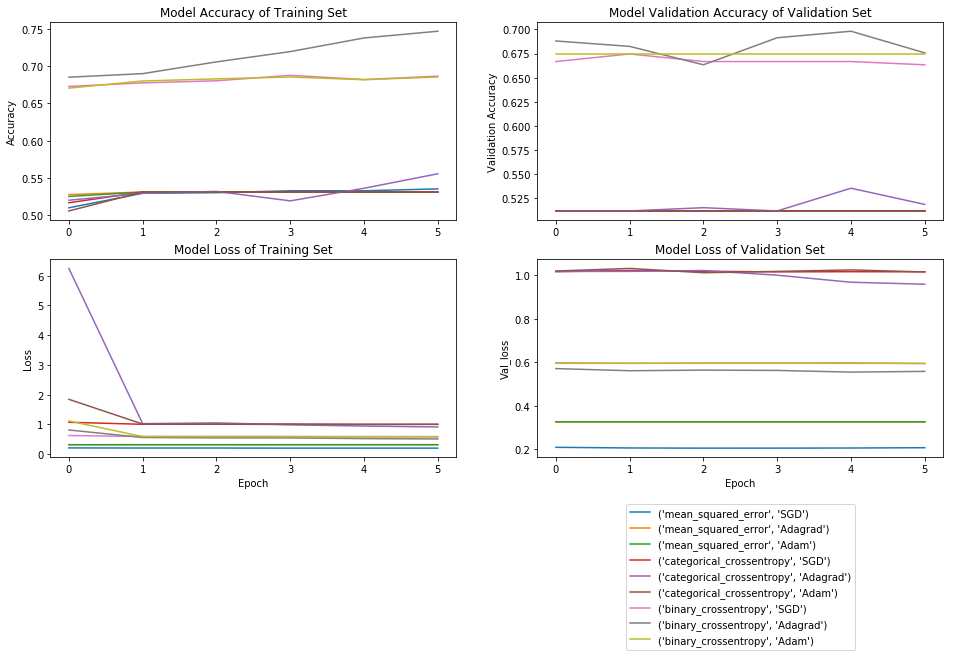

In [24]:
fig7 = plt.figure(figsize=(16,8))

for i, history in enumerate(test_combination_histories):
    ax1 = fig7.add_subplot(2,2,1)
    ax1.plot(history.history['acc'], label=combo_names[i])
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy of Training Set')

    ax2 = fig7.add_subplot(2,2,2)
    ax2.plot(history.history['val_acc'], label=combo_names[i])
    ax2.set_ylabel('Validation Accuracy')
    ax2.set_title('Model Validation Accuracy of Validation Set')
    
    ax3 = fig7.add_subplot(2,2,3)
    ax3.plot(history.history['loss'], label=combo_names[i])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Model Loss of Training Set')
    
    ax4 = fig7.add_subplot(2,2,4)
    ax4.plot(history.history['val_loss'], label=combo_names[i])
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Val_loss')
    ax4.set_title('Model Loss of Validation Set')
    ax4.legend(loc=8, bbox_to_anchor=(0.5, -1))
plt.show()

### FURTHER REDUCING NUMBER OF FEATURES

In [25]:
def build_model1_reduced_feature(loss_function, optimizer):
    model = Sequential()
    kernel_size=(3,3)
    data_size=(224,224,3)
    for i in range(5, 8):
        model.add(Conv2D(2^i, kernel_size, input_shape=data_size, data_format='channels_last'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.25))
        
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss=loss_function, optimizer = optimizer, 
                 metrics=['accuracy'])
    return model

In [27]:
test_combination_histories = []
test_combination_val_scores = []
test_combination_val_accs = []
test_combination_train_scores = []
test_combination_train_accs = []

for i in range(len(combinations)):
    loss_function = combinations[i][0]
    optimizer = combinations[i][1]
    print ('Loss function: ', loss_function)
    print ('Optimizer: ', optimizer)
    start_time = time.time()
    model = build_model1_reduced_feature(loss_function, optimizer)
    print (model.summary())
    modelcheckpoint = ModelCheckpoint('model1_checkpoint/Model1-reduced-feature-version2{}.h5'.format(str(combinations[i])), 
                                            monitor='val_acc', 
                                            verbose=0, save_best_only=True,  
                                            mode='auto', period=1)
    model_history = model.fit(X_train, Y_train, 
              batch_size=batch_size, 
             epochs=50, 
             callbacks=[modelcheckpoint], 
             validation_data=[X_valid, Y_valid])
    test_combination_histories.append(model_history)
    
    train_score, train_acc = model.evaluate(X_train, Y_train)
    test_combination_train_scores.append(train_score)
    test_combination_train_accs.append(train_acc)
    
    val_score, val_acc = model.evaluate(X_valid, Y_valid)
    test_combination_val_scores.append(val_score)
    test_combination_val_accs.append(val_acc)
    
    print ('Training time for this model is {}'.format(time.time()-start_time))
    print ('')
    print ('')

Loss function:  mean_squared_error
Optimizer:  <keras.optimizers.SGD object at 0x2b35fd846d68>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 222, 222, 7)       196       
_________________________________________________________________
activation_37 (Activation)   (None, 222, 222, 7)       0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 111, 111, 7)       0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 111, 111, 7)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 109, 109, 4)       256       
_________________________________________________________________
activation_38 (Activation)   (None, 109, 109, 4)       0         
_______________________________________________

Epoch 42/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.1405 - acc: 0.6968 - val_loss: 0.2036 - val_acc: 0.4815
Epoch 43/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.1459 - acc: 0.6858 - val_loss: 0.2157 - val_acc: 0.4747
Epoch 44/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.1393 - acc: 0.7061 - val_loss: 0.2164 - val_acc: 0.4815
Epoch 45/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.1335 - acc: 0.7128 - val_loss: 0.2141 - val_acc: 0.4882
Epoch 46/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.1235 - acc: 0.7365 - val_loss: 0.2076 - val_acc: 0.5253
Epoch 47/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.1231 - acc: 0.7416 - val_loss: 0.2156 - val_acc: 0.4916
Epoch 48/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.1204 - acc: 0.7441 - val_loss: 0.2240 - val_acc: 0.4983
Epoch 49/50
1184/1184 [==================

1184/1184 [==============================] - 32s 27ms/step - loss: 0.3122 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 32/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 33/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 34/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 35/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 36/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 37/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.3125 - acc: 0.5312 - val_loss: 0.3255 - val_acc: 0.5118
Epoch 38/50
1184/1184 [==============================

Epoch 21/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.1073 - acc: 0.7736 - val_loss: 0.2086 - val_acc: 0.5118
Epoch 22/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.0980 - acc: 0.8041 - val_loss: 0.2052 - val_acc: 0.5421
Epoch 23/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.0977 - acc: 0.8083 - val_loss: 0.2081 - val_acc: 0.5387
Epoch 24/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.0904 - acc: 0.8277 - val_loss: 0.2092 - val_acc: 0.5320
Epoch 25/50
1184/1184 [==============================] - 31s 26ms/step - loss: 0.0887 - acc: 0.8252 - val_loss: 0.2052 - val_acc: 0.5421
Epoch 26/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.0798 - acc: 0.8446 - val_loss: 0.2096 - val_acc: 0.5253
Epoch 27/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.0808 - acc: 0.8412 - val_loss: 0.2099 - val_acc: 0.4983
Epoch 28/50
1184/1184 [==================

1184/1184 [==============================] - 32s 27ms/step - loss: 0.9981 - acc: 0.5312 - val_loss: 1.0175 - val_acc: 0.5118
Epoch 11/50
1184/1184 [==============================] - 35s 30ms/step - loss: 0.9994 - acc: 0.5312 - val_loss: 1.0153 - val_acc: 0.5118
Epoch 12/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.9982 - acc: 0.5312 - val_loss: 1.0228 - val_acc: 0.5118
Epoch 13/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.9969 - acc: 0.5312 - val_loss: 1.0164 - val_acc: 0.5118
Epoch 14/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.9991 - acc: 0.5312 - val_loss: 1.0153 - val_acc: 0.5118
Epoch 15/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.9978 - acc: 0.5312 - val_loss: 1.0188 - val_acc: 0.5118
Epoch 16/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.9978 - acc: 0.5312 - val_loss: 1.0157 - val_acc: 0.5118
Epoch 17/50
1184/1184 [==============================

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 36s 30ms/step - loss: 1.0669 - acc: 0.5211 - val_loss: 1.0650 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.9911 - acc: 0.5304 - val_loss: 1.0625 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.9805 - acc: 0.5312 - val_loss: 1.0609 - val_acc: 0.5152
Epoch 4/50
1184/1184 [==============================] - 34s 28ms/step - loss: 0.9597 - acc: 0.5363 - val_loss: 1.0661 - val_acc: 0.5185
Epoch 5/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.9448 - acc: 0.5431 - val_loss: 1.0670 - val_acc: 0.5387
Epoch 6/50
1184/1184 [==============================] - 35s 29ms/step - loss: 0.9188 - acc: 0.5574 - val_loss: 1.0727 - val_acc: 0.4882
Epoch 7/50
1184/1184 [==============================] - 34s 28ms/step - loss: 0.9114 - acc: 0.5549 - val_loss: 1.0525 - val_acc: 0.5051
E

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 34s 29ms/step - loss: 1.2053 - acc: 0.5194 - val_loss: 1.0154 - val_acc: 0.5118
Epoch 2/50
1184/1184 [==============================] - 31s 27ms/step - loss: 0.9985 - acc: 0.5312 - val_loss: 1.0154 - val_acc: 0.5118
Epoch 3/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.9979 - acc: 0.5312 - val_loss: 1.0153 - val_acc: 0.5118
Epoch 4/50
1184/1184 [==============================] - 31s 26ms/step - loss: 1.0005 - acc: 0.5312 - val_loss: 1.0155 - val_acc: 0.5118
Epoch 5/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.9943 - acc: 0.5312 - val_loss: 1.0165 - val_acc: 0.5118
Epoch 6/50
1184/1184 [==============================] - 31s 27ms/step - loss: 0.9932 - acc: 0.5321 - val_loss: 1.0223 - val_acc: 0.5118
Epoch 7/50
1184/1184 [==============================] - 34s 28ms/step - loss: 0.9836 - acc: 0.5372 - val_loss: 1.0430 - val_acc: 0.5152
E

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.6030 - acc: 0.6836 - val_loss: 0.5962 - val_acc: 0.6745
Epoch 2/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.5901 - acc: 0.6754 - val_loss: 0.5949 - val_acc: 0.6689
Epoch 3/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.5873 - acc: 0.6824 - val_loss: 0.6039 - val_acc: 0.6667
Epoch 4/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.5905 - acc: 0.6760 - val_loss: 0.5947 - val_acc: 0.6745
Epoch 5/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.5853 - acc: 0.6847 - val_loss: 0.5948 - val_acc: 0.6745
Epoch 6/50
1184/1184 [==============================] - 33s 27ms/step - loss: 0.5840 - acc: 0.6881 - val_loss: 0.5943 - val_acc: 0.6790
Epoch 7/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.5839 - acc: 0.6833 - val_loss: 0.5951 - val_acc: 0.6745
E

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 35s 29ms/step - loss: 0.7514 - acc: 0.6734 - val_loss: 0.6244 - val_acc: 0.6667
Epoch 2/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.5928 - acc: 0.6872 - val_loss: 0.6215 - val_acc: 0.6667
Epoch 3/50
1184/1184 [==============================] - 35s 29ms/step - loss: 0.5867 - acc: 0.6875 - val_loss: 0.6187 - val_acc: 0.6667
Epoch 4/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.5838 - acc: 0.6909 - val_loss: 0.6176 - val_acc: 0.6667
Epoch 5/50
1184/1184 [==============================] - 35s 29ms/step - loss: 0.5809 - acc: 0.6872 - val_loss: 0.6169 - val_acc: 0.6667
Epoch 6/50
1184/1184 [==============================] - 33s 28ms/step - loss: 0.5735 - acc: 0.6906 - val_loss: 0.6153 - val_acc: 0.6667
Epoch 7/50
1184/1184 [==============================] - 36s 30ms/step - loss: 0.5566 - acc: 0.7089 - val_loss: 0.6090 - val_acc: 0.6655
E

Train on 1184 samples, validate on 297 samples
Epoch 1/50
1184/1184 [==============================] - 34s 29ms/step - loss: 0.6328 - acc: 0.6695 - val_loss: 0.6090 - val_acc: 0.6667
Epoch 2/50
1184/1184 [==============================] - 34s 28ms/step - loss: 0.5875 - acc: 0.6745 - val_loss: 0.6002 - val_acc: 0.6667
Epoch 3/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.5857 - acc: 0.6791 - val_loss: 0.6001 - val_acc: 0.6667
Epoch 4/50
1184/1184 [==============================] - 34s 28ms/step - loss: 0.5847 - acc: 0.6883 - val_loss: 0.6007 - val_acc: 0.6667
Epoch 5/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.5821 - acc: 0.6886 - val_loss: 0.5992 - val_acc: 0.6667
Epoch 6/50
1184/1184 [==============================] - 32s 27ms/step - loss: 0.5843 - acc: 0.6886 - val_loss: 0.5996 - val_acc: 0.6667
Epoch 7/50
1184/1184 [==============================] - 34s 28ms/step - loss: 0.5807 - acc: 0.6883 - val_loss: 0.6004 - val_acc: 0.6667
E

/home/ives/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


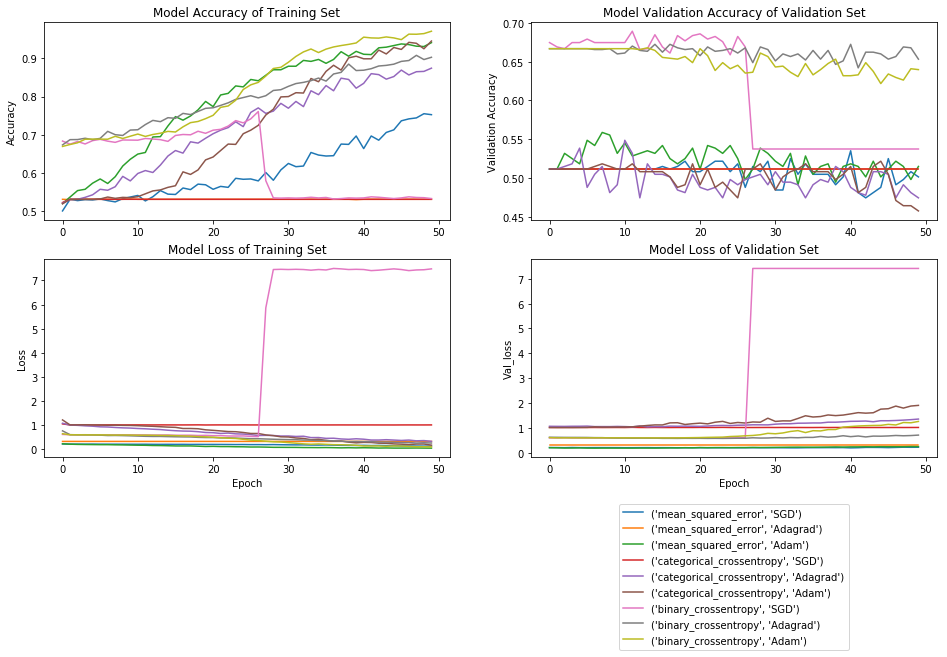

In [28]:
fig8 = plt.figure(figsize=(16,8))

for i, history in enumerate(test_combination_histories):
    ax1 = fig8.add_subplot(2,2,1)
    ax1.plot(history.history['acc'], label=combo_names[i])
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy of Training Set')

    ax2 = fig8.add_subplot(2,2,2)
    ax2.plot(history.history['val_acc'], label=combo_names[i])
    ax2.set_ylabel('Validation Accuracy')
    ax2.set_title('Model Validation Accuracy of Validation Set')
    
    ax3 = fig8.add_subplot(2,2,3)
    ax3.plot(history.history['loss'], label=combo_names[i])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.set_title('Model Loss of Training Set')
    
    ax4 = fig8.add_subplot(2,2,4)
    ax4.plot(history.history['val_loss'], label=combo_names[i])
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Val_loss')
    ax4.set_title('Model Loss of Validation Set')
    ax4.legend(loc=8, bbox_to_anchor=(0.5, -1))
plt.show()

In [29]:
best_acc = max(test_combination_val_accs)
best_acc_idx = test_combination_val_accs.index(best_acc)
best_combo = combinations[best_acc_idx]
print ('The best loss-function/optimizer combination is ', combinations[best_acc_idx])

The best loss-function/optimizer combination is  ('binary_crossentropy', <keras.optimizers.Adagrad object at 0x2b35fd846d30>)


### PREDICTION

In [31]:
from keras.models import load_model
reduced_feature_model1_version1 = load_model("model1_checkpoint/Model1-reduced-feature-('binary_crossentropy', <keras.optimizers.SGD object at 0x2b35fd846d68>).h5")
reduced_feature_model1_version2 = load_model("model1_checkpoint/Model1-reduced-feature-version2('binary_crossentropy', <keras.optimizers.SGD object at 0x2b35fd846d68>).h5")

In [32]:
test_label_predicted_by_version1 = reduced_feature_model1_version1.predict_classes(test_data)
test_label_predicted_by_version2 = reduced_feature_model1_version2.predict_classes(test_data)

In [33]:
test_label_predicted_by_version1 = test_label_predicted_by_version1 + 1
test_label_predicted_by_version2 = test_label_predicted_by_version2 + 1

In [35]:
test_label_solution = pd.read_csv('solution_stg1_release.csv')

In [36]:
test_id_images = [x.split('/')[-1] for x in test_id_]
img_no_data = []
for img in test_label_solution.image_name.values:
    if img not in test_id_images:
        img_no_data.append(img)

In [37]:
test_label_solution = test_label_solution[test_label_solution.image_name.isin(img_no_data) == False]
subset = test_label_solution[['Type_1', 'Type_2', 'Type_3']]
test_label_solution = [list(x) for x in subset.values]

In [38]:
new_test_labels_solution = []
for label in test_label_solution:
    if label == [1, 0, 0]:
        label = 1
        new_test_labels_solution.append(label)
    elif label == [0, 1, 0]:
        label = 2
        new_test_labels_solution.append(label)
    else:
        label =3
        new_test_labels_solution.append(label)

        Y_test = np.array(new_test_labels_solution)

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score_version1 = accuracy_score(Y_test, test_label_predicted_by_version1)
accuracy_score_version2 = accuracy_score(Y_test, test_label_predicted_by_version2)
print ('The accuracy obtained by running model1 with reduced feature version 1 is ', accuracy_score_version1)
print ('The accuracy obtained by running model1 with reduced feature version 2 is ', accuracy_score_version2)

The accuracy obtained by running model1 with reduced feature version 1 is  0.5168986083499006
The accuracy obtained by running model1 with reduced feature version 2 is  0.5168986083499006
